#Data Loading and Inspection

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
import xgboost as xgb
import lightgbm as lgb
import pickle
import warnings
warnings.filterwarnings('ignore')

In [2]:
from google.colab import files
import io


# Dynamically ask for the dataset file
uploaded = files.upload()

# Assuming only one file is uploaded, get the filename
filename = next(iter(uploaded))

# Load the dataset
df = pd.read_csv(io.StringIO(uploaded[filename].decode('utf-8')))
print(df.head())
print(df.info())
print(df.describe())

Saving CAR DETAILS FROM CAR DEKHO.csv to CAR DETAILS FROM CAR DEKHO.csv
                       name  year  selling_price  km_driven    fuel  \
0             Maruti 800 AC  2007          60000      70000  Petrol   
1  Maruti Wagon R LXI Minor  2007         135000      50000  Petrol   
2      Hyundai Verna 1.6 SX  2012         600000     100000  Diesel   
3    Datsun RediGO T Option  2017         250000      46000  Petrol   
4     Honda Amaze VX i-DTEC  2014         450000     141000  Diesel   

  seller_type transmission         owner  
0  Individual       Manual   First Owner  
1  Individual       Manual   First Owner  
2  Individual       Manual   First Owner  
3  Individual       Manual   First Owner  
4  Individual       Manual  Second Owner  
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4340 entries, 0 to 4339
Data columns (total 8 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   name           4340 non-null   object
 1   yea

#Data Cleaning & Preprocessing

In [3]:
# Remove duplicate rows
initial_count = df.shape[0]
df_clean = df.drop_duplicates()
print(f"Dropped {initial_count - df_clean.shape[0]} duplicate rows.")
print("Missing values per column:\n", df_clean.isnull().sum())

Dropped 763 duplicate rows.
Missing values per column:
 name             0
year             0
selling_price    0
km_driven        0
fuel             0
seller_type      0
transmission     0
owner            0
dtype: int64


No Missing Values.

In [4]:
df_clean = df_clean.dropna().reset_index(drop=True)

In [5]:
# Standardize categorical columns
cat_cols = ['fuel', 'seller_type', 'transmission', 'owner']
for col in cat_cols:
    df_clean[col] = df_clean[col].astype(str).str.strip().str.title()
df_clean

,name,year,selling_price,km_driven,fuel,seller_type,transmission,owner
0,Maruti 800 AC,2007,60000,70000,Petrol,Individual,Manual,First Owner
1,Maruti Wagon R LXI Minor,2007,135000,50000,Petrol,Individual,Manual,First Owner
2,Hyundai Verna 1.6 SX,2012,600000,100000,Diesel,Individual,Manual,First Owner
3,Datsun RediGO T Option,2017,250000,46000,Petrol,Individual,Manual,First Owner
4,Honda Amaze VX i-DTEC,2014,450000,141000,Diesel,Individual,Manual,Second Owner
...,...,...,...,...,...,...,...,...
3572,Hyundai i20 Magna 1.4 CRDi (Diesel),2014,409999,80000,Diesel,Individual,Manual,Second Owner
3573,Hyundai i20 Magna 1.4 CRDi,2014,409999,80000,Diesel,Individual,Manual,Second Owner
3574,Maruti 800 AC BSIII,2009,110000,83000,Petrol,Individual,Manual,Second Owner
3575,Hyundai Creta 1.6 CRDi SX Option,2016,865000,90000,Diesel,Individual,Manual,First Owner


#Feature Engineering

In [6]:
# Feature Engineering
CURRENT_YEAR = 2025
df_clean['car_age'] = CURRENT_YEAR - df_clean['year']
df_clean = df_clean[(df_clean['car_age'] >= 0) & (df_clean['car_age'] <= 50)].reset_index(drop=True)

# Remove outliers
price_upper_limit = df_clean['selling_price'].quantile(0.99)
df_clean = df_clean[df_clean['selling_price'] <= price_upper_limit]
km_upper_limit = df_clean['km_driven'].quantile(0.99)
df_clean = df_clean[df_clean['km_driven'] <= km_upper_limit].reset_index(drop=True)

# One-hot encoding categorical variables with drop_first to avoid dummy trap
df_encoded = pd.get_dummies(df_clean, columns=cat_cols, drop_first=False)
print(df_encoded.columns.tolist())

# Scale numerical features including target
scaler = StandardScaler()
numeric_features = ['selling_price','km_driven', 'car_age']
df_encoded[numeric_features] = scaler.fit_transform(df_encoded[numeric_features])


['name', 'year', 'selling_price', 'km_driven', 'car_age', 'fuel_Cng', 'fuel_Diesel', 'fuel_Electric', 'fuel_Lpg', 'fuel_Petrol', 'seller_type_Dealer', 'seller_type_Individual', 'seller_type_Trustmark Dealer', 'transmission_Automatic', 'transmission_Manual', 'owner_First Owner', 'owner_Fourth & Above Owner', 'owner_Second Owner', 'owner_Test Drive Car', 'owner_Third Owner']


# Visualization

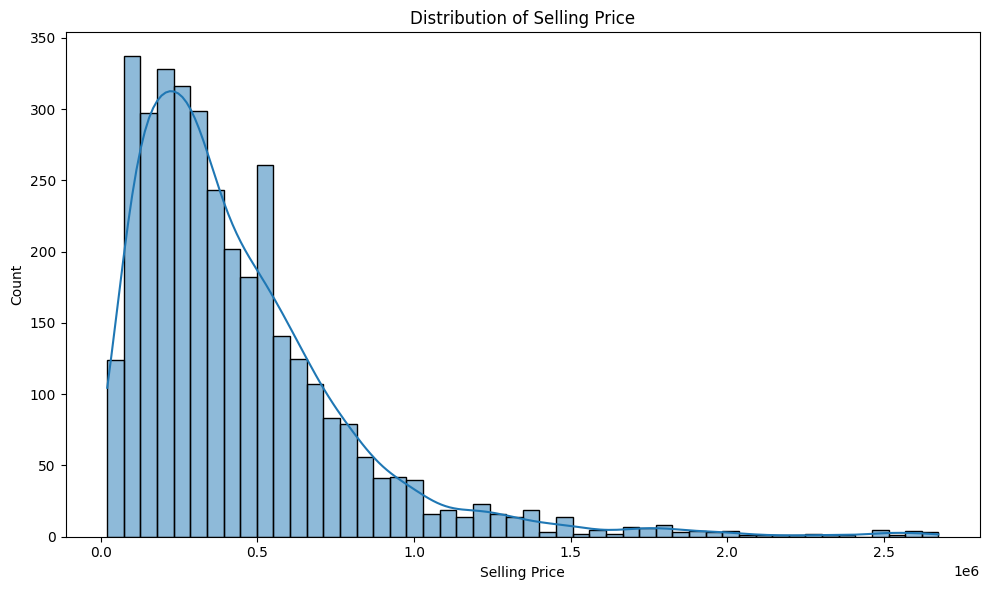

In [7]:
# 1. Distribution of Selling Price
plt.figure(figsize=(10, 6))
sns.histplot(df_clean['selling_price'], bins=50, kde=True)
plt.title('Distribution of Selling Price')
plt.xlabel('Selling Price')
plt.ylabel('Count')
plt.tight_layout()
plt.show()

**Interpretation**

- Most cars are sold at prices below approximately 500,000 units, indicating a concentration of sales in the lower to mid-range price segment.

- The distribution is right-skewed, meaning there are fewer high-priced cars sold, but some expensive cars do exist, reaching up to around 2.5 million units or more.

- The peak around 100,000 to 300,000 units suggests that the bulk of the market demand is in affordable and mid-range cars.

- The long tail to the right reflects luxury or high-value cars, which are less common but extend the price range significantly.

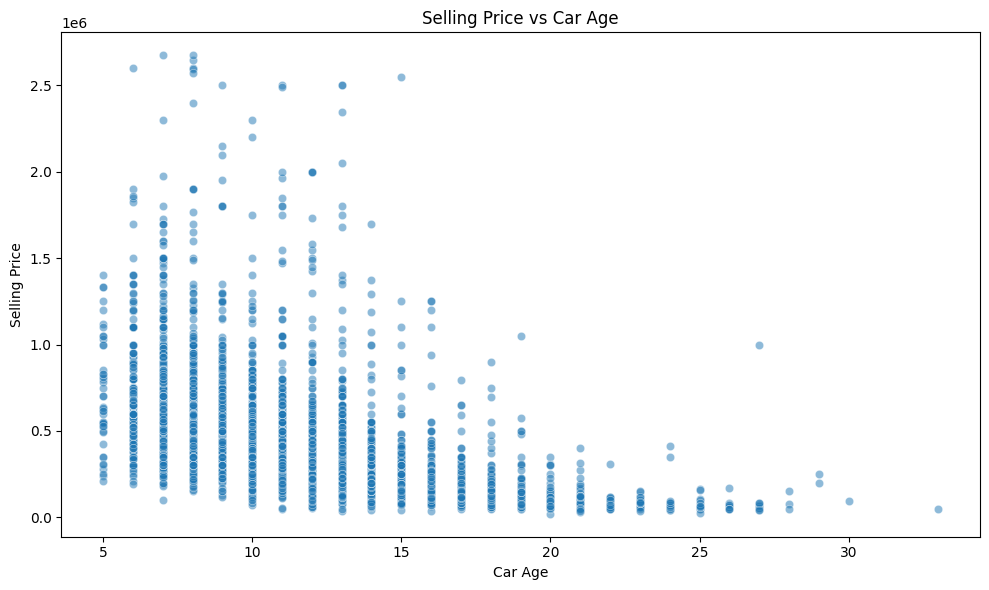

In [8]:
# 2. Selling Price vs Car Age
plt.figure(figsize=(10, 6))
sns.scatterplot(x='car_age', y='selling_price', data=df_clean, alpha=0.5)
plt.title('Selling Price vs Car Age')
plt.xlabel('Car Age')
plt.ylabel('Selling Price')
plt.tight_layout()
plt.show()

**Insights**

- Newer cars (lower age) generally sell at higher prices, and as the car ages, prices tend to decrease significantly.

- The scatter of points shows a clear downward trend, indicating depreciation: older cars are worth less.

- There is more price variation among younger cars, with some very expensive outliers, whereas older cars have much lower and more consistent prices.

- Only a few older cars command high prices, which could represent rare, collectible, or specialty vehicles.



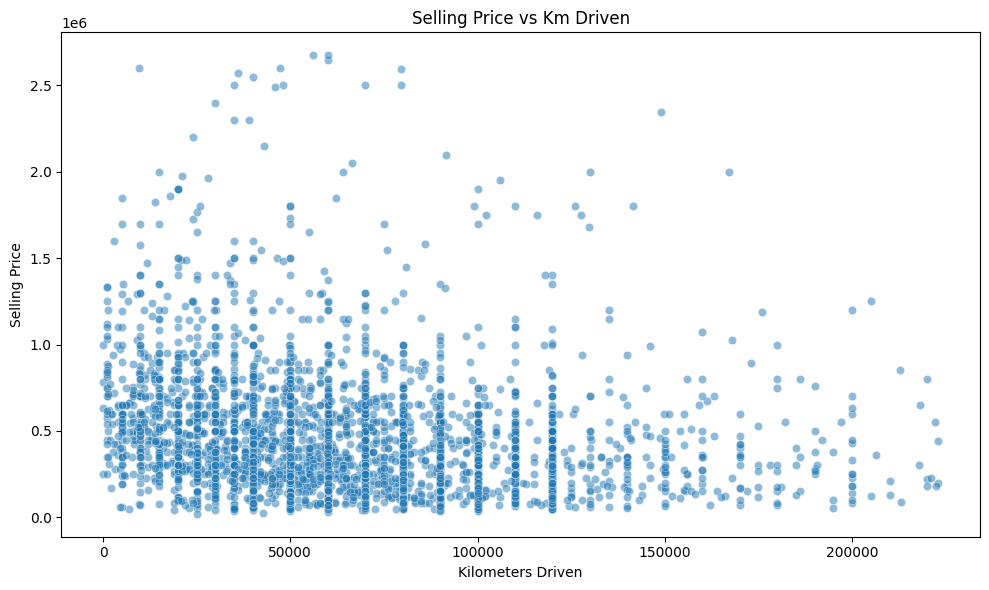

In [9]:
# 3. Selling Price vs Km Driven
plt.figure(figsize=(10, 6))
sns.scatterplot(x='km_driven', y='selling_price', data=df_clean, alpha=0.5)
plt.title('Selling Price vs Km Driven')
plt.xlabel('Kilometers Driven')
plt.ylabel('Selling Price')
plt.tight_layout()
plt.show()

**Insights**

- A general trend is visible: as the number of kilometers driven increases, the selling price tends to decrease.

- There is a wide variation in selling prices for cars with lower kilometers, with prices clustering more tightly and dropping as kilometers increase.

- High-priced sales are much rarer for vehicles with high mileage, whereas most of the cheaper cars are those with both high kilometers and possibly older models.

- Some outliers exist—cars with high kilometers but still selling for high prices, which could be due to brand, model, or unique features.



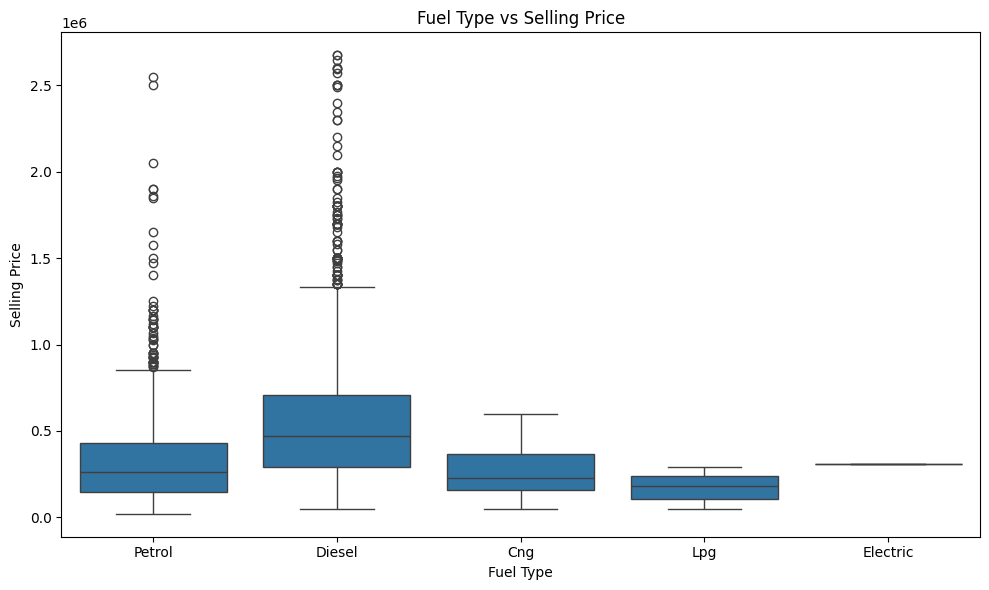

In [10]:
# 4. Fuel Type vs Selling Price (Boxplot)
plt.figure(figsize=(10, 6))
sns.boxplot(x='fuel', y='selling_price', data=df_clean)
plt.title('Fuel Type vs Selling Price')
plt.xlabel('Fuel Type')
plt.ylabel('Selling Price')
plt.tight_layout()
plt.show()


**Insights**

- Diesel cars generally have the highest median and range of selling prices, with many outliers at high values.

- Petrol cars have slightly lower prices compared to diesel but are the next highest group, also with many outliers.

- CNG and LPG cars show lower median selling prices, and few outliers, indicating more concentrated price distributions at the lower end.

- Electric cars appear to have less variation and a lower range, possibly due to fewer sales data points.

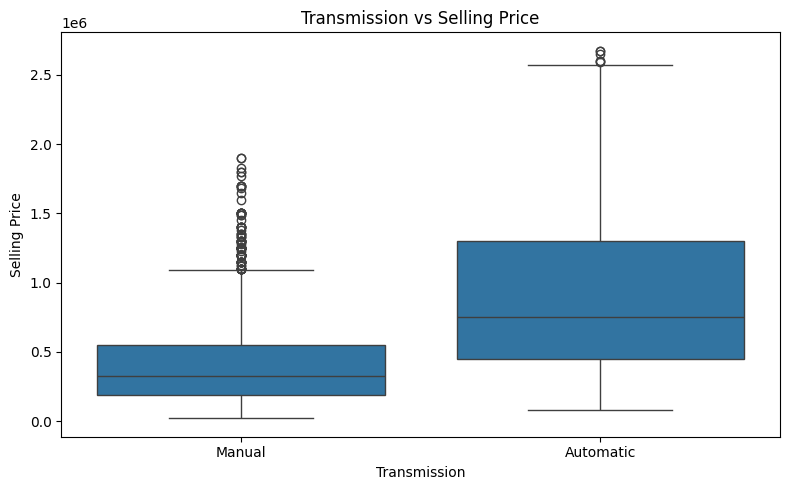

In [11]:
# 5. Transmission vs Selling Price (Boxplot)
plt.figure(figsize=(8, 5))
sns.boxplot(x='transmission', y='selling_price', data=df_clean)
plt.title('Transmission vs Selling Price')
plt.xlabel('Transmission')
plt.ylabel('Selling Price')
plt.tight_layout()
plt.show()

**Insights**

- Automatic cars have a noticeably higher median selling price compared to manual cars.

- The price distribution for automatics stretches over a broader range, with higher maximum selling prices and more high-value outliers than manuals.

- Manual cars are typically sold at lower prices, with fewer outliers and a tighter price spread.



# Train/Test Split

In [12]:
X = df_encoded.drop(columns=['name', 'year', 'selling_price'])
y = df_encoded['selling_price']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
train_data = lgb.Dataset(X_train, label=y_train)
test_data = lgb.Dataset(X_test, label=y_test, reference=train_data)


In [17]:
# Initialize models
lr_model = LinearRegression()
rf_model = RandomForestRegressor(random_state=42)
lgb_model = lgb.LGBMRegressor(random_state=42, verbose=-1)
gb_model = GradientBoostingRegressor(random_state=42)
xgb_model = xgb.XGBRegressor(random_state=42, objective='reg:squarederror')

print("All models initialized successfully")

All models initialized successfully


In [18]:
'''
# Set parameters for LightGBM
params = {
    'objective': 'regression',
    'metric': 'rmse',
    'boosting_type': 'gbdt',
    'learning_rate': 0.1,
    'num_leaves': 31,
    'verbose': -1
}
'''

"\n# Set parameters for LightGBM\nparams = {\n    'objective': 'regression',\n    'metric': 'rmse',\n    'boosting_type': 'gbdt',\n    'learning_rate': 0.1,\n    'num_leaves': 31,\n    'verbose': -1\n}\n"

In [19]:
# Train model with early stopping
# lgb_model = lgb.train(params, train_data, valid_sets=[test_data], callbacks=[lgb.early_stopping(stopping_rounds=50, verbose=100)])

In [20]:
# Train models
# Train base models first for comparison
print("Training base models...")
lr_model.fit(X_train, y_train)
rf_model.fit(X_train, y_train)
lgb_model.fit(X_train, y_train)
gb_model.fit(X_train, y_train)
xgb_model.fit(X_train, y_train)
print("Base model training complete!")

Training base models...
Base model training complete!


In [21]:
# Make predictions with base models
lr_pred = lr_model.predict(X_test)
rf_pred = rf_model.predict(X_test)
lgb_pred = lgb_model.predict(X_test)
gb_pred = gb_model.predict(X_test)
xgb_pred = xgb_model.predict(X_test)

# Model Development & Evaluation

In [22]:
# Evaluation function
def evaluate_model(name, y_true, y_pred):
    r2 = r2_score(y_true, y_pred)
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    print(f"{name} Performance:")
    print(f"  R² Score: {r2:.4f}")
    print(f"  MAE: ₹{mae:,.2f}")
    print(f"  RMSE: ₹{rmse:,.2f}\n")
    return {'R2': r2, 'MAE': mae, 'RMSE': rmse}

# Evaluate all base models
print("="*60)
print("BASE MODEL EVALUATION (Before Hyperparameter Tuning)")
print("="*60 + "\n")

results = {}
results['Linear Regression'] = evaluate_model("Linear Regression", y_test, lr_pred)
results['Random Forest'] = evaluate_model("Random Forest", y_test, rf_pred)
results['LightGBM'] = evaluate_model("LightGBM", y_test, lgb_pred)
results['Gradient Boosting'] = evaluate_model("Gradient Boosting", y_test, gb_pred)
results['XGBoost'] = evaluate_model("XGBoost", y_test, xgb_pred)


BASE MODEL EVALUATION (Before Hyperparameter Tuning)

Linear Regression Performance:
  R² Score: 0.5091
  MAE: ₹0.48
  RMSE: ₹0.74

Random Forest Performance:
  R² Score: 0.4302
  MAE: ₹0.48
  RMSE: ₹0.79

LightGBM Performance:
  R² Score: 0.4928
  MAE: ₹0.45
  RMSE: ₹0.75

Gradient Boosting Performance:
  R² Score: 0.5439
  MAE: ₹0.43
  RMSE: ₹0.71

XGBoost Performance:
  R² Score: 0.4085
  MAE: ₹0.48
  RMSE: ₹0.81




Model Comparison Summary:
                       R2     MAE    RMSE
Linear Regression  0.5091  0.4768  0.7371
Random Forest      0.4302  0.4809  0.7941
LightGBM           0.4928  0.4539  0.7492
Gradient Boosting  0.5439  0.4259  0.7105
XGBoost            0.4085  0.4766  0.8091


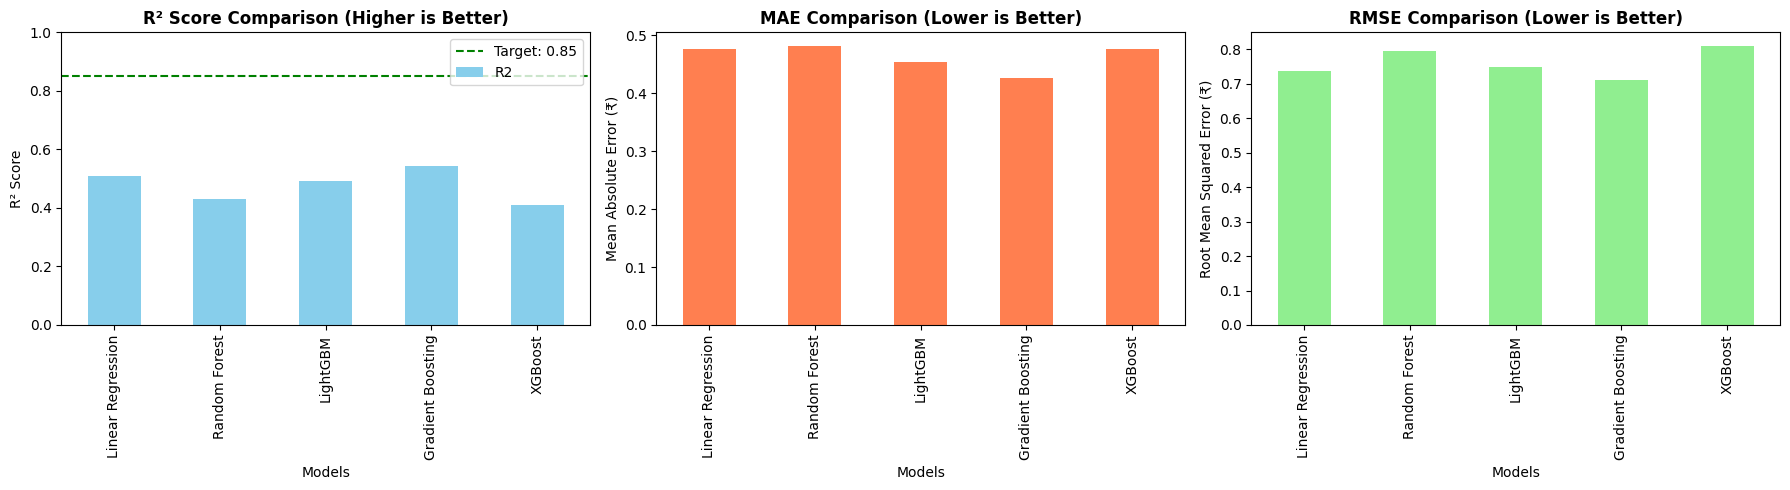


✅ Best Base Model: Gradient Boosting
   R² Score: 0.5439


In [23]:
# Visualize model comparison
import pandas as pd

results_df = pd.DataFrame(results).T
results_df = results_df.round(4)

print("\nModel Comparison Summary:")
print(results_df)

# Bar plot comparison
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# R² Score
results_df['R2'].plot(kind='bar', ax=axes[0], color='skyblue')
axes[0].set_title('R² Score Comparison (Higher is Better)', fontsize=12, fontweight='bold')
axes[0].set_ylabel('R² Score')
axes[0].set_xlabel('Models')
axes[0].set_ylim(0, 1)
axes[0].axhline(y=0.85, color='green', linestyle='--', label='Target: 0.85')
axes[0].legend()

# MAE
results_df['MAE'].plot(kind='bar', ax=axes[1], color='coral')
axes[1].set_title('MAE Comparison (Lower is Better)', fontsize=12, fontweight='bold')
axes[1].set_ylabel('Mean Absolute Error (₹)')
axes[1].set_xlabel('Models')

# RMSE
results_df['RMSE'].plot(kind='bar', ax=axes[2], color='lightgreen')
axes[2].set_title('RMSE Comparison (Lower is Better)', fontsize=12, fontweight='bold')
axes[2].set_ylabel('Root Mean Squared Error (₹)')
axes[2].set_xlabel('Models')

plt.tight_layout()
plt.show()

# Find best model
best_model_name = results_df['R2'].idxmax()
print(f"\n✅ Best Base Model: {best_model_name}")
print(f"   R² Score: {results_df.loc[best_model_name, 'R2']:.4f}")


In [24]:
print("\n" + "="*60)
print("HYPERPARAMETER TUNING WITH GRID SEARCH")
print("="*60 + "\n")

# Grid Search for Random Forest
print("🔍 Tuning Random Forest...")
rf_params = {
    'n_estimators': [100, 200, 300],
    'max_depth': [10, 20, 30, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

rf_grid = GridSearchCV(
    RandomForestRegressor(random_state=42),
    rf_params,
    cv=3,
    scoring='r2',
    n_jobs=-1,
    verbose=1
)
rf_grid.fit(X_train, y_train)
print(f"Best RF Parameters: {rf_grid.best_params_}")
print(f"Best RF R² Score: {rf_grid.best_score_:.4f}\n")

# Grid Search for Gradient Boosting
print("🔍 Tuning Gradient Boosting...")
gb_params = {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 5, 7],
    'min_samples_split': [2, 5, 10]
}

gb_grid = GridSearchCV(
    GradientBoostingRegressor(random_state=42),
    gb_params,
    cv=3,
    scoring='r2',
    n_jobs=-1,
    verbose=1
)
gb_grid.fit(X_train, y_train)
print(f"Best GB Parameters: {gb_grid.best_params_}")
print(f"Best GB R² Score: {gb_grid.best_score_:.4f}\n")

# Grid Search for XGBoost
print("🔍 Tuning XGBoost...")
xgb_params = {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 5, 7],
    'subsample': [0.8, 0.9, 1.0],
    'colsample_bytree': [0.8, 0.9, 1.0]
}

xgb_grid = GridSearchCV(
    xgb.XGBRegressor(random_state=42, objective='reg:squarederror'),
    xgb_params,
    cv=3,
    scoring='r2',
    n_jobs=-1,
    verbose=1
)
xgb_grid.fit(X_train, y_train)
print(f"Best XGB Parameters: {xgb_grid.best_params_}")
print(f"Best XGB R² Score: {xgb_grid.best_score_:.4f}\n")



HYPERPARAMETER TUNING WITH GRID SEARCH

🔍 Tuning Random Forest...
Fitting 3 folds for each of 108 candidates, totalling 324 fits
Best RF Parameters: {'max_depth': 10, 'min_samples_leaf': 4, 'min_samples_split': 2, 'n_estimators': 300}
Best RF R² Score: 0.5817

🔍 Tuning Gradient Boosting...
Fitting 3 folds for each of 81 candidates, totalling 243 fits
Best GB Parameters: {'learning_rate': 0.1, 'max_depth': 3, 'min_samples_split': 10, 'n_estimators': 100}
Best GB R² Score: 0.5948

🔍 Tuning XGBoost...
Fitting 3 folds for each of 243 candidates, totalling 729 fits
Best XGB Parameters: {'colsample_bytree': 1.0, 'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 100, 'subsample': 0.9}
Best XGB R² Score: 0.5951



In [25]:
print("\n" + "="*60)
print("TUNED MODEL EVALUATION (After Hyperparameter Tuning)")
print("="*60 + "\n")

# Make predictions with tuned models
rf_tuned_pred = rf_grid.predict(X_test)
gb_tuned_pred = gb_grid.predict(X_test)
xgb_tuned_pred = xgb_grid.predict(X_test)

# Evaluate tuned models
tuned_results = {}
tuned_results['Random Forest (Tuned)'] = evaluate_model("Random Forest (Tuned)", y_test, rf_tuned_pred)
tuned_results['Gradient Boosting (Tuned)'] = evaluate_model("Gradient Boosting (Tuned)", y_test, gb_tuned_pred)
tuned_results['XGBoost (Tuned)'] = evaluate_model("XGBoost (Tuned)", y_test, xgb_tuned_pred)

# Compare tuned results
tuned_df = pd.DataFrame(tuned_results).T
print("\nTuned Model Comparison:")
print(tuned_df.round(4))

# Find best tuned model
best_tuned_name = tuned_df['R2'].idxmax()
print(f"\n✅ Best Tuned Model: {best_tuned_name}")
print(f"   R² Score: {tuned_df.loc[best_tuned_name, 'R2']:.4f}")
print(f"   MAE: ₹{tuned_df.loc[best_tuned_name, 'MAE']:,.2f}")
print(f"   RMSE: ₹{tuned_df.loc[best_tuned_name, 'RMSE']:,.2f}")



TUNED MODEL EVALUATION (After Hyperparameter Tuning)

Random Forest (Tuned) Performance:
  R² Score: 0.5114
  MAE: ₹0.44
  RMSE: ₹0.74

Gradient Boosting (Tuned) Performance:
  R² Score: 0.5435
  MAE: ₹0.43
  RMSE: ₹0.71

XGBoost (Tuned) Performance:
  R² Score: 0.5398
  MAE: ₹0.43
  RMSE: ₹0.71


Tuned Model Comparison:
                               R2     MAE    RMSE
Random Forest (Tuned)      0.5114  0.4412  0.7354
Gradient Boosting (Tuned)  0.5435  0.4272  0.7108
XGBoost (Tuned)            0.5398  0.4273  0.7137

✅ Best Tuned Model: Gradient Boosting (Tuned)
   R² Score: 0.5435
   MAE: ₹0.43
   RMSE: ₹0.71



FINAL MODEL COMPARISON: BASE vs TUNED

                               R2     MAE    RMSE
Gradient Boosting          0.5439  0.4259  0.7105
Gradient Boosting (Tuned)  0.5435  0.4272  0.7108
XGBoost (Tuned)            0.5398  0.4273  0.7137
Random Forest (Tuned)      0.5114  0.4412  0.7354
Linear Regression          0.5091  0.4768  0.7371
LightGBM                   0.4928  0.4539  0.7492
Random Forest              0.4302  0.4809  0.7941
XGBoost                    0.4085  0.4766  0.8091


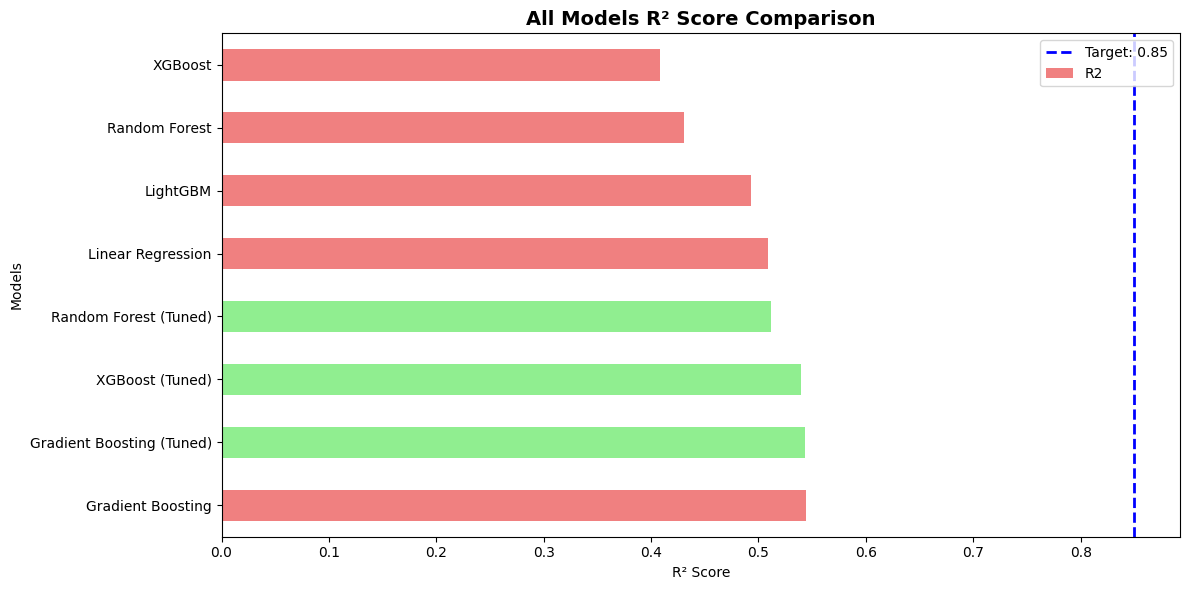


🏆 FINAL BEST MODEL: Gradient Boosting
   R² Score: 0.5439
   MAE: ₹0.43
   RMSE: ₹0.71


In [26]:
# Combined comparison
print("\n" + "="*60)
print("FINAL MODEL COMPARISON: BASE vs TUNED")
print("="*60 + "\n")

all_results = {**results, **tuned_results}
all_results_df = pd.DataFrame(all_results).T
all_results_df = all_results_df.sort_values('R2', ascending=False)

print(all_results_df.round(4))

# Visualization
fig, ax = plt.subplots(figsize=(12, 6))
all_results_df['R2'].plot(kind='barh', ax=ax, color=['lightcoral' if 'Tuned' not in idx else 'lightgreen' for idx in all_results_df.index])
ax.set_title('All Models R² Score Comparison', fontsize=14, fontweight='bold')
ax.set_xlabel('R² Score')
ax.set_ylabel('Models')
ax.axvline(x=0.85, color='blue', linestyle='--', linewidth=2, label='Target: 0.85')
ax.legend()
plt.tight_layout()
plt.show()

# Determine final best model
final_best = all_results_df.index[0]
print(f"\n🏆 FINAL BEST MODEL: {final_best}")
print(f"   R² Score: {all_results_df.iloc[0]['R2']:.4f}")
print(f"   MAE: ₹{all_results_df.iloc[0]['MAE']:,.2f}")
print(f"   RMSE: ₹{all_results_df.iloc[0]['RMSE']:,.2f}")


In [30]:
# NOW save the best model after complete evaluation
print("\n" + "="*60)
print("SAVING BEST MODEL")
print("="*60 + "\n")

# Determine which model to save based on best performance
if 'Random Forest (Tuned)' in final_best:
    best_model = rf_grid.best_estimator_
    model_name = 'random_forest_tuned'
elif 'Gradient Boosting (Tuned)' in final_best:
    best_model = gb_grid.best_estimator_
    model_name = 'gradient_boosting_tuned'
elif 'XGBoost (Tuned)' in final_best:
    best_model = xgb_grid.best_estimator_
    model_name = 'xgboost_tuned'
else:
    # Fallback to best base model
    if final_best == 'Random Forest':
        best_model = rf_model
        model_name = 'random_forest_base'
        model="rf"
    elif final_best == 'Gradient Boosting':
        best_model = gb_model
        model_name = 'gradient_boosting_base'
        model = "gb"
    elif final_best == 'XGBoost':
        best_model = xgb_model
        model_name = 'xgboost_base'
        model = "xgb"

# Save the best model
with open(f'{model}_model.pkl', 'wb') as f:
    pickle.dump(best_model, f)

with open('scaler.pkl', 'wb') as f:
    pickle.dump(scaler, f)

print(f"✅ Best model saved as: {model}_model.pkl")
print(f"   Model Type: {final_best}")
print(f"   Performance: R² = {all_results_df.iloc[0]['R2']:.4f}")

# Also save feature names for future predictions
feature_names = X_train.columns.tolist()
with open('feature_names.pkl', 'wb') as f:
    pickle.dump(feature_names, f)
print(f"✅ Feature names saved as: feature_names.pkl")



SAVING BEST MODEL

✅ Best model saved as: gb_model.pkl
   Model Type: Gradient Boosting
   Performance: R² = 0.5439
✅ Feature names saved as: feature_names.pkl


In [28]:
print("\n" + "="*60)
print("PROJECT SUMMARY")
print("="*60)
print(f"\n📊 Dataset: {df_clean.shape[0]} rows, {df_clean.shape[1]} columns")
print(f"📊 Training Set: {X_train.shape[0]} samples")
print(f"📊 Test Set: {X_test.shape[0]} samples")
print(f"\n🤖 Models Trained: 8")
print("   - Linear Regression (Base)")
print("   - Random Forest (Base + Tuned)")
print("   - LightGBM (Base)")
print("   - Gradient Boosting (Base + Tuned)")
print("   - XGBoost (Base + Tuned)")
print(f"\n🏆 Best Model: {final_best}")
print(f"   R² Score: {all_results_df.iloc[0]['R2']:.4f}")
print(f"   MAE: ₹{all_results_df.iloc[0]['MAE']:,.2f}")
print(f"   RMSE: ₹{all_results_df.iloc[0]['RMSE']:,.2f}")
print("\n✅ All models evaluated BEFORE saving")
print("✅ Grid Search applied for hyperparameter tuning")
print("✅ XGBoost Regressor included")
print("✅ Gradient Boosting properly compared")
print(f"✅ Best model saved as: {model_name}_model.pkl")
print("\n" + "="*60)



PROJECT SUMMARY

📊 Dataset: 3506 rows, 9 columns
📊 Training Set: 2804 samples
📊 Test Set: 702 samples

🤖 Models Trained: 8
   - Linear Regression (Base)
   - Random Forest (Base + Tuned)
   - LightGBM (Base)
   - Gradient Boosting (Base + Tuned)
   - XGBoost (Base + Tuned)

🏆 Best Model: Gradient Boosting
   R² Score: 0.5439
   MAE: ₹0.43
   RMSE: ₹0.71

✅ All models evaluated BEFORE saving
✅ Grid Search applied for hyperparameter tuning
✅ XGBoost Regressor included
✅ Gradient Boosting properly compared
✅ Best model saved as: gradient_boosting_base_model.pkl

